In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from datetime import datetime

In [2]:
file_path_volts1 = r".\dataset\H1\Tagged_Training_04_13_1334300401\LF1V.csv"
file_path_amps1 = r".\dataset\H1\Tagged_Training_04_13_1334300401\LF1I.csv"
file_path_time_ticks1 = r".\dataset\H1\Tagged_Training_04_13_1334300401\TimeTicks1.csv"

file_path_volts2 = r".\dataset\H1\Tagged_Training_04_13_1334300401\LF2V.csv"
file_path_amps2 = r".\dataset\H1\Tagged_Training_04_13_1334300401\LF2I.csv"
file_path_time_ticks2 = r".\dataset\H1\Tagged_Training_04_13_1334300401\TimeTicks2.csv"

file_path_labels = r".\dataset\H1\Tagged_Training_04_13_1334300401\TaggingInfo.csv"

LF1V = pd.read_csv(file_path_volts1)
LF1I = pd.read_csv(file_path_amps1)
time_ticks1 = pd.read_csv(file_path_time_ticks1)

LF2V = pd.read_csv(file_path_volts2)
LF2I = pd.read_csv(file_path_amps2)
time_ticks2 = pd.read_csv(file_path_time_ticks2)

labels = pd.read_csv(file_path_labels)

In [3]:
LF1V = np.array(LF1V)
LF1I = np.array(LF1I)
LF1V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1V])
LF1I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1I])

LF2V = np.array(LF2V)
LF2I = np.array(LF2I)
LF2V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2V])
LF2I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2I])

In [4]:
L1_P = LF1V * np.conjugate(LF1I)
L2_P = LF2V * np.conjugate(LF2I)

L1_ComplexPower = np.sum(L1_P, axis=1)
L2_ComplexPower = np.sum(L2_P, axis=1)

L1_real = np.real(L1_ComplexPower)
L1_imag = np.imag(L1_ComplexPower)
L1_app = np.abs(L1_ComplexPower)

L2_real = np.real(L2_ComplexPower)
L2_imag = np.imag(L2_ComplexPower)
L2_app = np.abs(L2_ComplexPower)

L1_Pf = np.cos(np.angle(L1_P[:, 0]))
L2_Pf = np.cos(np.angle(L2_P[:, 0]))

L1_actual_power = L1_real * L1_Pf
L2_actual_power = L2_real * L2_Pf

power = L1_actual_power + L2_actual_power[:len(L2_actual_power) - 1]

In [5]:
time_ticks1_datetime = pd.to_datetime(time_ticks1.iloc[:, 0], unit='s')
TS1_real = np.array(time_ticks1_datetime)

time_ticks2_datetime = pd.to_datetime(time_ticks2.iloc[:, 0], unit='s')
TS2_real = np.array(time_ticks2_datetime)

In [6]:
print(TS1_real[0])
print(TS1_real[len(TS1_real) - 1])

print(TS2_real[0])
print(TS2_real[len(TS1_real) - 1])

2012-04-13T07:00:01.188921600
2012-04-14T06:59:58.918994944
2012-04-13T07:00:01.170224896
2012-04-14T06:59:58.794994688


In [7]:
labels["ON_Time"] = pd.to_datetime(labels["ON_Time"], unit='s')
labels["OFF_Time"] = pd.to_datetime(labels["OFF_Time"], unit='s')

In [8]:
labels.head()

,ApplianceID,ApplianceName,ON_Time,OFF_Time
0,38,Washer,2012-04-13 22:21:30,2012-04-13 22:27:00
1,16,Dryer,2012-04-13 22:27:00,2012-04-13 22:28:30
2,35,Toaster,2012-04-13 22:34:00,2012-04-13 22:34:30
3,32,Portable Vacuum,2012-04-13 22:42:00,2012-04-13 22:43:30
4,8,Central Vacuum,2012-04-13 22:44:00,2012-04-13 22:44:30


TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

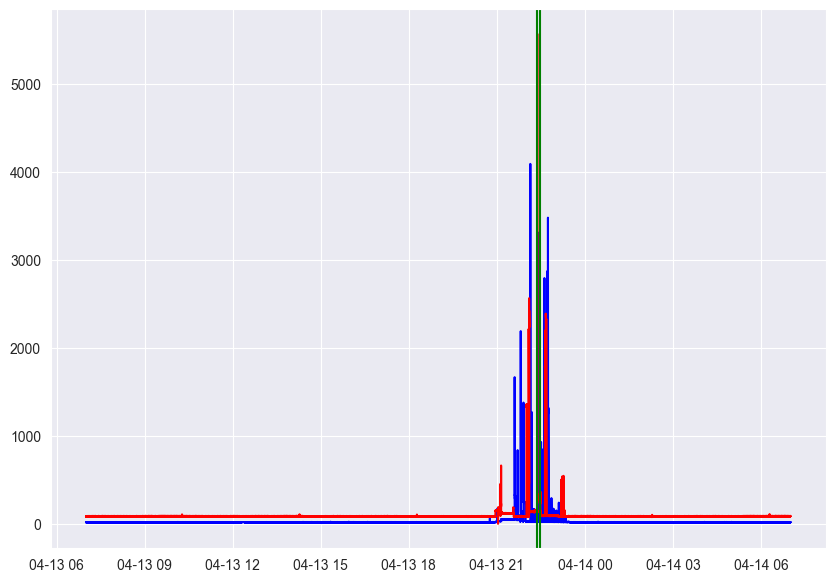

In [18]:

plt.figure(figsize=(10, 7))
plt.plot(TS1_real, L1_actual_power, linestyle='-', color='b', label='L1')
plt.plot(TS2_real, L2_actual_power, linestyle='-', color='r', label='L2')
plt.axvline(x=labels["ON_Time"][0], color="green")
plt.axvline(x=labels["OFF_Time"][0], color="green")
plt.xlim(labels["ON_Time"][0], labels["ON_Time"][0] + 10)
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

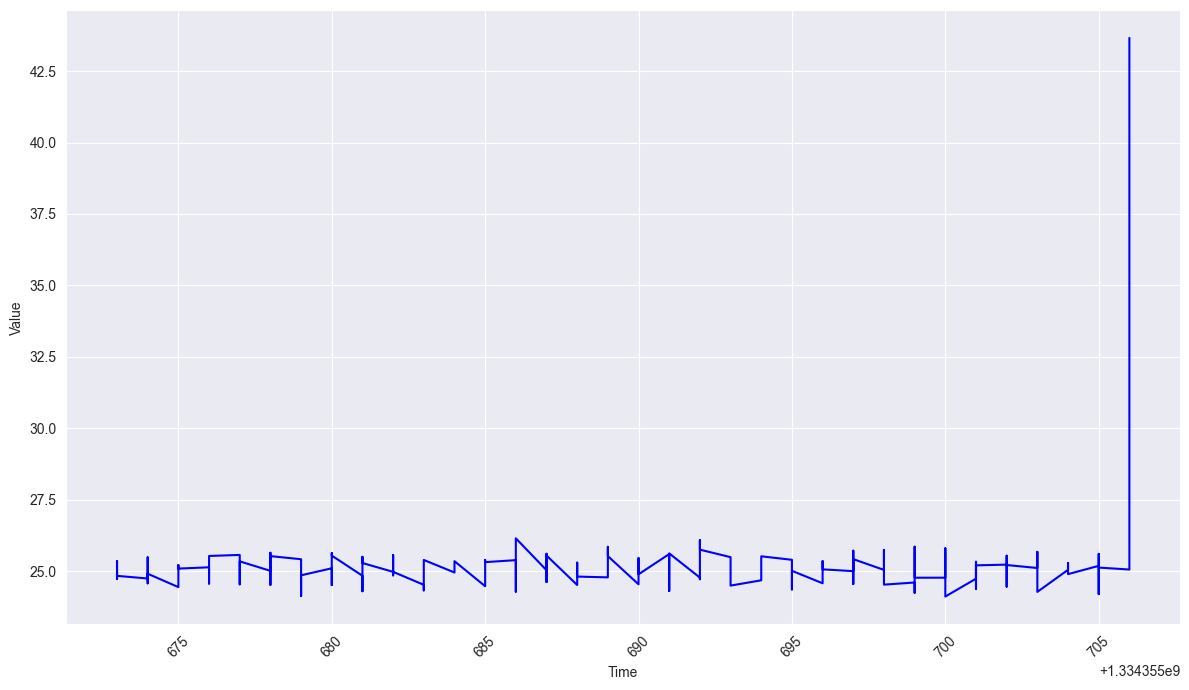

In [17]:
# Convert the specified human-readable time into a UNIX timestamp
specified_unix_time = int((pd.Timestamp('2012-04-13 22:21:30') - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))

# Ensure that time_ticks2 is in integer format
time_ticks2_int = time_ticks2.astype(int)

# Find the nearest UNIX timestamp to the specified time
nearest_index = np.abs(np.array(time_ticks2_int - specified_unix_time)).argmin()

# Choose a window around the nearest time (e.g., 100 data points before and 100 data points after)
window = 100
start_index = max(0, nearest_index - window)  # Ensure you don't go below 0
end_index = nearest_index + window  # This can exceed the array length, but Python will handle it gracefully

# Subset your data
subset_time_unix = time_ticks2_int[start_index:end_index]
subset_data = L1_actual_power[start_index:end_index]  # Replace L1_app_demo with your actual data array

# Convert subset_time_unix to human-readable datetime for plotting
#subset_time = pd.to_datetime(subset_time_unix, unit='s')

# Plot the data subset
plt.figure(figsize=(12, 7))
plt.plot(subset_time_unix, subset_data, linestyle='-', color='b')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()